<a href="https://colab.research.google.com/github/JCSR2022/Alura_Data_Science/blob/main/Testing_Relationships_with_Linear_Regression/precios_de_inmuebles_regresion_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Precificación inmobiliaria**

**Objetivo**: Estimar los precios de los inmuebles.
 * Identificar los aspectos que tienen más influencia en la precificación de los inmuebles.
 * Entender cuál de todos estos aspectos es el más relevante.
 * Precificar un inmueble nuevo.

Base de datos simplificada e inspirada en [House Prices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)



![](https://i.imgur.com/A8X79yq.jpeg)


# 0. Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px


import plotly.graph_objects as go
from scipy.stats import gaussian_kde

# 1. Ajustando una recta

## Conociendo los datos

In [2]:
#Leyendo los datos

#direccion original
#https://github.com/JCSR2022/Alura_Data_Science/blob/main/Testing_Relationships_with_Linear_Regression/precios_casas.csv

git_raw = 'https://raw.githubusercontent.com/'
url_github = 'JCSR2022/Alura_Data_Science/main/Testing_Relationships_with_Linear_Regression/precios_casas.csv'
datos = pd.read_csv(git_raw + url_github)

datos.head()

,Id,area_primer_piso,tiene_segundo_piso,area_segundo_piso,cantidad_banos,capacidad_carros_garage,calidad_de_cocina_excelente,precio_de_venta
0,1,79.5224,1,79.3366,2,548,0,1027905.0
1,2,117.2398,0,0.0000,2,460,0,894795.0
2,3,85.4680,1,80.4514,2,608,0,1101855.0
3,4,89.2769,1,70.2324,1,642,0,690200.0
4,5,106.3705,1,97.8237,2,836,0,1232500.0


In [3]:
#Cuáles factores fueron colectados
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           1438 non-null   int64  
 1   area_primer_piso             1438 non-null   float64
 2   tiene_segundo_piso           1438 non-null   int64  
 3   area_segundo_piso            1438 non-null   float64
 4   cantidad_banos               1438 non-null   int64  
 5   capacidad_carros_garage      1438 non-null   int64  
 6   calidad_de_cocina_excelente  1438 non-null   int64  
 7   precio_de_venta              1438 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 90.0 KB


In [4]:
datos = datos.drop(columns='Id')
datos.columns

Index(['area_primer_piso', 'tiene_segundo_piso', 'area_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente', 'precio_de_venta'],
      dtype='object')

## Correlación

**¿Cuáles factores están relacionados con el precio de la casa? ¿Cómo es esa relación?**

El coeficiente de correlación de Pearson nos permite medir la relación lineal entre variables, ofreciendo una escala que varía de -1 a 1, la cual interpretamos según su intensidad y dirección:

* **-1**: correlación negativa perfecta: a medida que una variable aumenta, la otra disminuye.  
* **0**: no hay relación lineal entre las variables.  
* **1**: correlación positiva perfecta: a medida que una variable aumenta, la otra también aumenta.  



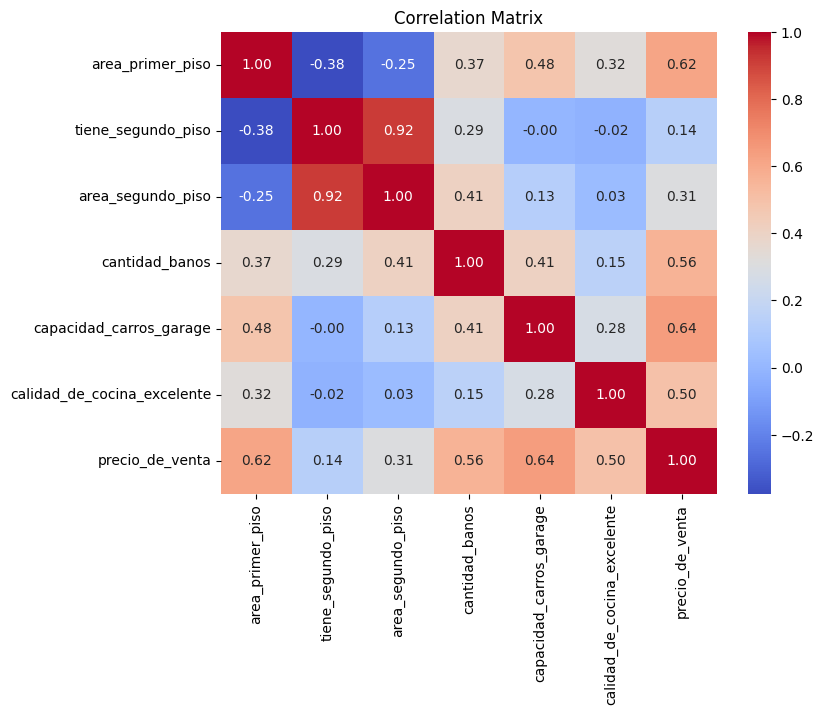

In [5]:
# Correlación
corr = datos.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

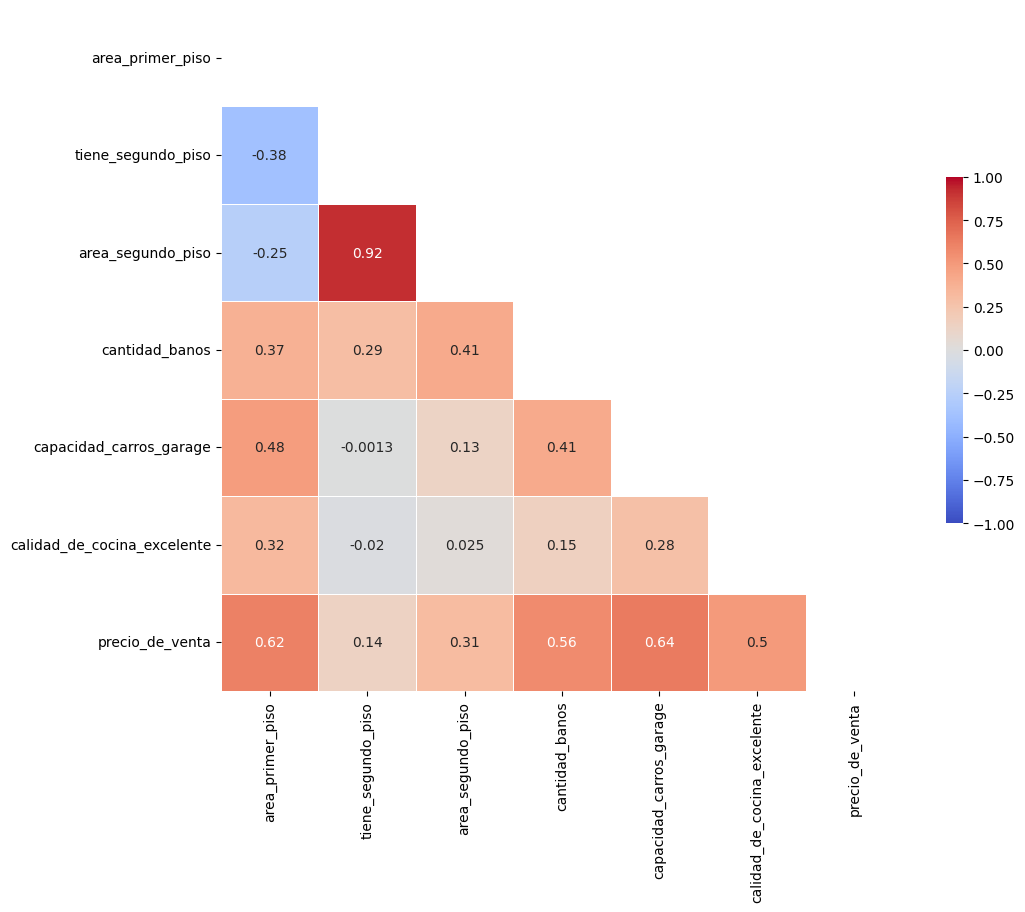

In [6]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mascara, cmap='coolwarm' , vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Mostrar el mapa de calor (heatmap)
plt.show()

In [7]:
corr_precio = corr['precio_de_venta'].sort_values(ascending=False).drop('precio_de_venta')
vis_corr_precio = (
    corr_precio
    .to_frame(name='Correlation with Sale Price')
    .style
    .background_gradient(cmap='coolwarm')
    .format("{:.3f}")
)

display(vis_corr_precio)


,Correlation with Sale Price
capacidad_carros_garage,0.640
area_primer_piso,0.617
cantidad_banos,0.563
calidad_de_cocina_excelente,0.496
area_segundo_piso,0.305
tiene_segundo_piso,0.139


In [8]:
# Actividad
# Cuáles factores están más correlacionados?

def top_correlations(corr_matrix, n=5):
    """
    Returns the top n most correlated variable pairs
    (by absolute correlation value).
    """

    # Copiamos la matriz
    corr = corr_matrix.copy()

    # Nos quedamos con el triángulo superior (sin diagonal)
    upper_triangle = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )

    # Convertimos a formato largo
    corr_pairs = (
        upper_triangle
        .stack()
        .reset_index()
    )

    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

    # Ordenamos por valor absoluto
    corr_pairs = corr_pairs.reindex(
        corr_pairs['Correlation'].abs().sort_values(ascending=False).index
    )
    corr_pairs.reset_index(drop=True, inplace=True)
    return corr_pairs.head(n)


top_correlations(corr)

,Variable 1,Variable 2,Correlation
0,tiene_segundo_piso,area_segundo_piso,0.917101
1,capacidad_carros_garage,precio_de_venta,0.640214
2,area_primer_piso,precio_de_venta,0.616557
3,cantidad_banos,precio_de_venta,0.563132
4,calidad_de_cocina_excelente,precio_de_venta,0.496223


## Relacionando variables

In [9]:
# creando funciones standar para la visualización

def plot_scatter(df, x, y,unit_x=None,unit_y=None,corr=None,add_reg_line=True, color='steelblue'):
    """
    Plots a scatter plot between two variables
    with optional regression line.
    """

    plt.figure(figsize=(8,5))

    ax = sns.scatterplot(
        data=df,
        x=x,
        y=y,
        color=color,
        alpha=0.7
    )

    # Add regression line
    if add_reg_line:
        sns.regplot(
            data=df,
            x=x,
            y=y,
            scatter=False,
            color='darkred',
            ax=ax
        )

    ax.set_title(f'Relationship between {x} and {y} \n{f"correlation:{corr:.6f}" if corr else ''}', fontsize=13)
    ax.set_xlabel(x+(' ['+unit_x+']' if unit_x else ''), fontsize=11)
    ax.set_ylabel(y+(' ['+unit_y+']' if unit_y else ''), fontsize=11)

    sns.despine()  # clean look
    plt.tight_layout()

    return plt



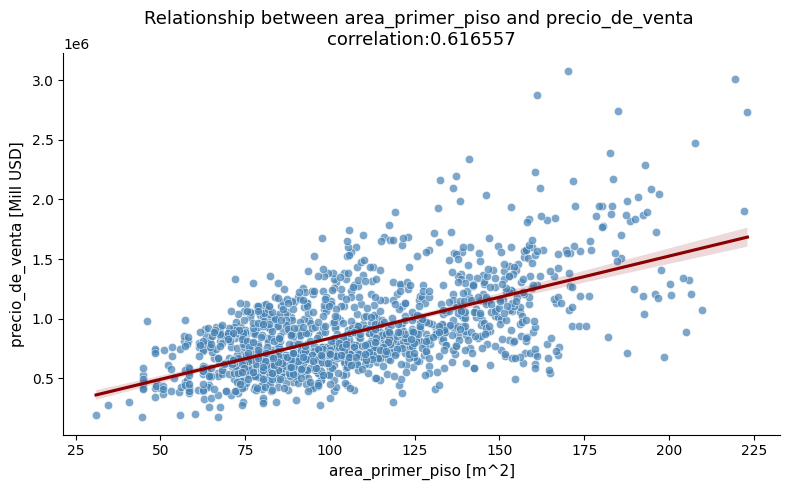

In [10]:
# Cómo se relacionan el área construída y el precio del inmueble?
corr_area_precio = corr.loc['area_primer_piso','precio_de_venta']
#print(f'Correlación entre area_primer_piso y precio_de_venta: {corr_area_precio:.5f}')
#print()
plot_scatter(datos, 'area_primer_piso', 'precio_de_venta','m^2','Mill USD',corr_area_precio).show()

In [11]:
# Aparentemente mientras mayor es el área del primer piso, mayor es el precio de la casa.
# E si quisieramos trazar una línea que nos permita describir este comportamiento?

#px.scatter(datos, x='area_primer_piso', y='precio_de_venta', trendline='ols', trendline_color_override='red')


def plot_scatter(df, x, y, unit_x=None, unit_y=None,
                 corr=None, add_reg_line=True, color='steelblue'):
    """
    Interactive scatter plot using Plotly Express
    with optional OLS regression line.
    """

    # Compute correlation if not provided
    if corr is None:
        corr = df[[x, y]].corr().iloc[0, 1]

    # Axis labels with units
    x_label = x + (f" [{unit_x}]" if unit_x else "")
    y_label = y + (f" [{unit_y}]" if unit_y else "")

    # Title
    title_text = (
        f"Relationship between {x} and {y}"
        f"<br><sup>Correlation: {corr:.6f}</sup>"
    )

    fig = px.scatter(
        df,
        x=x,
        y=y,
        trendline="ols" if add_reg_line else None,
        color_discrete_sequence=[color],
        opacity=0.7
    )

    # Update layout for professional look
    fig.update_layout(
        title=title_text,
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="simple_white",
        width=800,
        height=500
    )

    # Change regression line color (if exists)
    if add_reg_line:
        fig.data[1].line.color = "darkred"

    return fig

## Mejor recta

In [12]:
# Cuál es la recta que mejor se ajusta a esta relación
plot_scatter(datos, 'area_primer_piso', 'precio_de_venta','m^2','Mill USD').show()

# 2. Explicando la recta
Ajustamos una recta entre los $m^2$ del primer piso y el precio de la casa. Queremos explicar el precio de la casa a partir de su tamaño, por eso decimos que:

* Variable explicativa/independiente: Área del primer piso  
* Variable de respuesta/dependiente: Precio de la casa  

In [13]:
#Quién es nuestra variable de respuesta?

# sns.displot(datos, x='precio_de_venta', kde=True)
# plt.show()

def dist_plot(df, column, unit=None, bins=30, color='steelblue', show_kde=True):
    """
    Parameters:
    - df: DataFrame
    - column: column name to analyze
    - unit: optional unit string (e.g., 'BRL', 'm²')
    - bins: number of histogram bins
    - color: histogram color
    - show_kde: whether to overlay KDE curve
    """

    data = df[column].dropna()

    # Basic statistics
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()

    label = column + (f" [{unit}]" if unit else "")

    # Histogram
    fig = px.histogram(
        df,
        x=column,
        nbins=bins,
        opacity=0.75,
        color_discrete_sequence=[color]
    )

    # KDE curve
    if show_kde:
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 500)
        y_kde = kde(x_range)

        # Scale KDE to histogram
        y_kde_scaled = y_kde * len(data) * (data.max() - data.min()) / bins

        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=y_kde_scaled,
                mode='lines',
                name='KDE',
                line=dict(color='darkred', width=2)
            )
        )

    # # Add mean and median lines
    # fig.add_vline(x=mean_val, line_dash="dash",
    #               line_color="green",
    #               annotation_text="Mean",
    #               annotation_position="top left")

    # fig.add_vline(x=median_val, line_dash="dot",
    #               line_color="purple",
    #               annotation_text="Median",
    #               annotation_position="top right")

    # Layout
    fig.update_layout(
        title=f"Distribution of {column}"
              f"<br><sup>Mean: {mean_val:.2f} | "
              f"Median: {median_val:.2f} | "
              f"Std: {std_val:.2f}</sup>",
        xaxis_title=label,
        yaxis_title="Frequency",
        template="simple_white",
        width=850,
        height=500
    )

    return fig

dist_plot(datos,'precio_de_venta','Mill USD').show()

### Separando datos para entrenamiento y para prueba

El conjunto de **entrenamiento** se utiliza para ajustar el modelo, mientras que el conjunto de **prueba** se usa para evaluar su desempeño al predecir precios de viviendas no vistos durante el entrenamiento, lo que ayuda a la generalización del modelo.

In [14]:
# import train_test_split
from sklearn.model_selection import train_test_split

#set random
my_random_state = 230

In [15]:
#Datos de entrenamiento para usar la fórmula

y = datos['precio_de_venta']
x = datos.drop(columns='precio_de_venta')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=my_random_state)

df_train = pd.DataFrame(x_train)
df_train['precio_de_venta'] = y_train

df_test = pd.DataFrame(x_test)
df_test['precio_de_venta'] = y_test


train_test_split permite Estratificación,
train_test_split(x, y, test_size=0.3, stratify=y) garantiza que: Si 20% de los datos son clase 1,entonces 20% del train y 20% del test también lo serán.

ejemplo:
Dataset original: 90% A | 10% B
Sin estratificación puedes tener:
Train: 97% A | 3% B
Test: 85% A | 15% B

Con estratificación:
Train: 90% A | 10% B
Test: 90% A | 10% B



En proyectos reales ni siquiera se usa solo train_test_split, se usa:
-KFold
-StratifiedKFold
-cross_val_score

## Construyendo el modelo

https://www.statsmodels.org/stable/regression.html

Ordinary Least Squares (OLS) is a statistical method used to estimate
the parameters of a linear regression model by minimizing the
sum of squared residuals between observed and predicted values.
Python's statsmodels library provides a robust implementation
of OLS for linear regression analysis.

In [16]:
# import ols
from statsmodels.formula.api import ols

modelo_0 = ols(formula='precio_de_venta ~ area_primer_piso', data=df_train).fit()



In [17]:
# ajustando el primer modelo


## Analizando los coeficientes

(intensidad, dirección y significancia)




In [18]:
# visualizando los parámetros
modelo_0.params

,0
Intercept,152909.288334
area_primer_piso,6793.641641


In [19]:
# El resumen del modelo
modelo_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        precio_de_venta   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     608.3
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          2.22e-105
Time:                        17:07:19   Log-Likelihood:                -14082.
No. Observations:                1006   AIC:                         2.817e+04
Df Residuals:                    1004   BIC:                         2.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.529e+05   3.07e+04      4.981      0.000    9.27e+04    2.13e+05
area_primer_piso  6793.6416    275.455     24.663      0.000    6253.109    7334.175
==============================================================================
Omnibus:                      190.778   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.457
Skew:                           0.998   Prob(JB):                    1.72e-105
Kurtosis:                       5.743   Cond. No.                         373.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- El **punto de intercepción** es el valor esperado del precio de la casa cuando todas las demás variables son cero. En este caso, cuando todas las demás variables, incluida el área del primer piso, son cero, el precio esperado de la casa es de $145.196,40. No siempre se tiene una interpretación práctica para este número.

- El **efecto individual** del área es de \$6.833,97. Esto indica que por cada metro cuadrado adicional al área del primer piso, se espera que el precio de la casa aumente en promedio \$6.833,97.

<img src="https://i.ibb.co/CJwfMgW/coeficientes.png" alt="coeficientes" border="0">


Y = β₀ + β₁*Xi
Variable Respuesta (Y): También llamada variable dependiente, es aquella que estamos tratando de predecir.

Intercepto (β₀): El punto donde la línea de regresión intercepta el eje vertical (Y), es decir, el valor de Y cuando X es igual a 0.

Variable Explicativa (X): También llamada variable independiente, es el factor que usamos para predecir y explicar la variable respuesta.

Coeficientes de Regresión (β₁): Impacto de cada variable explicativa X en la variable respuesta, es el efecto de X en Y.

Error Residual (e): Diferencia entre los valores reales y previstos de la variable respuesta.

## Explicabilidad del modelo

**¿En qué medida la variación del área explica los diversos precios de las casas?**  

En este caso, recurrimos a la métrica R², el coeficiente de determinación. El R² varía de 0 a 1, donde 1 indica un ajuste perfecto del modelo a los datos, es decir, todas las variaciones en la variable dependiente son explicadas por las variables independientes en el modelo. Por otro lado, un R² de 0 indica que el modelo no explica ninguna variabilidad en la variable dependiente.

In [20]:
# observando el R²
modelo_0.rsquared

np.float64(0.37728010994297867)

## Entendiendo el resíduo

In [21]:
# Quiénes son los residuos?
modelo_0.resid

,0
1303,-193023.838744
326,-144522.356193
386,399612.747641
615,-68449.596607
236,166010.592859
...,...
777,465872.680999
271,-497642.319788
723,461150.204718
560,-540482.733402


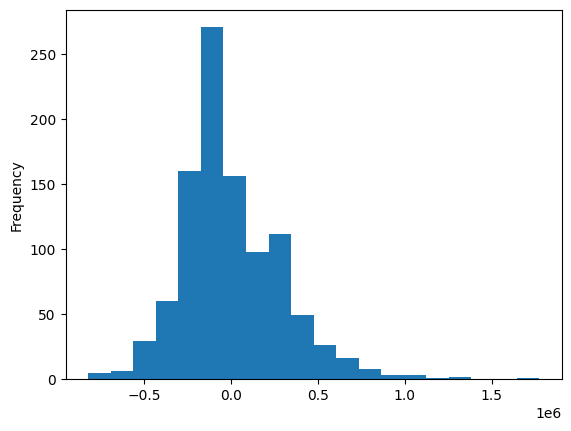

In [22]:
# Cómo están distribuidos
modelo_0.resid.plot.hist(bins=20)
plt.show()



<img src="https://i.ibb.co/zGTB35V/residuos.png" alt="residuos" border="0">

## Obteniendo el R² de la previsión

In [23]:
# definiendo la 'Y' prevista
y_predict = modelo_0.predict(x_test)

In [24]:
# importando el r2_score
from sklearn.metrics import r2_score

In [25]:
# mostrando el resultado de r²
print(f"Coeficiente de determinacion: {r2_score(y_test, y_predict):.2f}")

Coeficiente de determinacion: 0.39


# 3. Añadiendo otras características

El modelo con un solo factor nos mostró un R² de 0.38, es decir, aproximadamente el 38% de la variación observada en los precios de las casas puede explicarse por la variación en el área.  
Esto indica que aún existe una cantidad significativa de variación que no está siendo capturada por este modelo específico. Analizaremos otros factores para explicar el precio de las casas.

## Analizando los factores

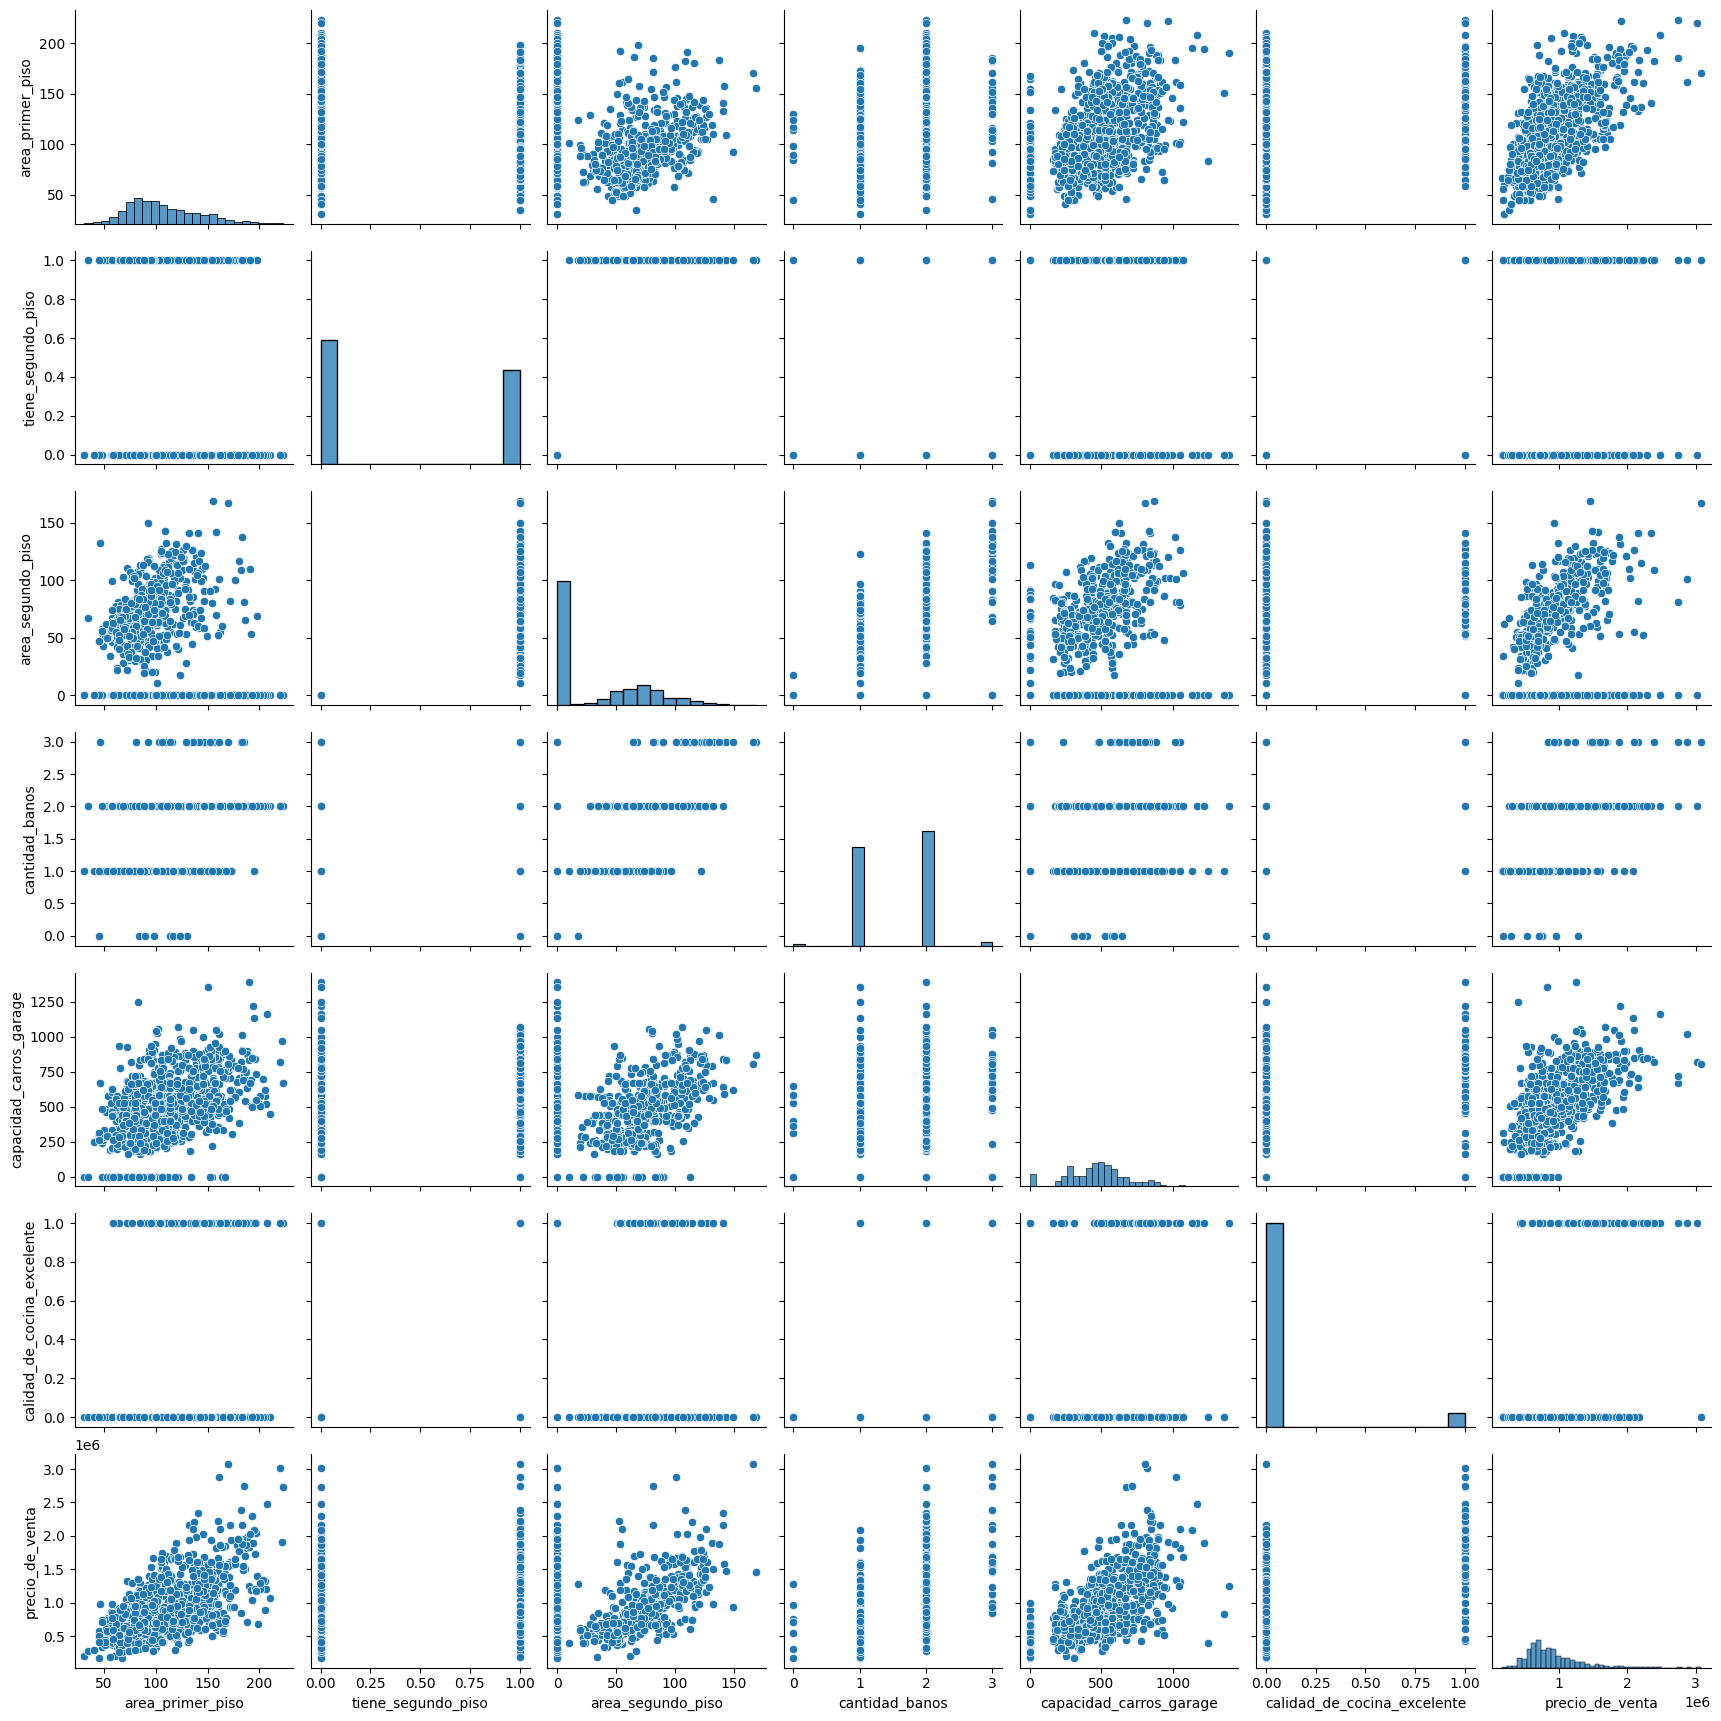

In [26]:
# cuáles otras características podrían explicar el precio de los inmuebles?
sns.pairplot(datos)

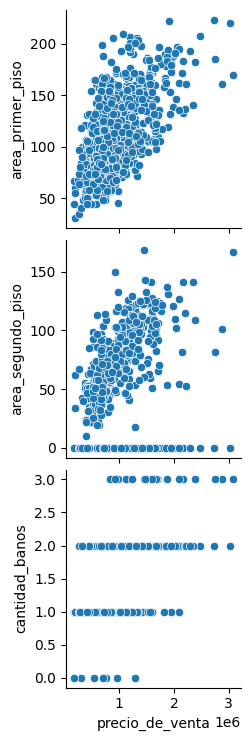

In [27]:
#Vamos a analizar solamente y_vars='precio_de_venta'
sns.pairplot(datos, y_vars=['area_primer_piso','area_segundo_piso','cantidad_banos'],x_vars='precio_de_venta')
#

## Añadiendo factores al modelo

In [28]:
# importando la api de statsmodels
import statsmodels.api as sm

In [29]:
# Añadiendo una constante
x_train = sm.add_constant(x_train)
x_train.head()

,const,area_primer_piso,tiene_segundo_piso,area_segundo_piso,cantidad_banos,capacidad_carros_garage,calidad_de_cocina_excelente
1303,1.0,65.7732,0,0.0000,1,0,0
326,1.0,55.3684,1,55.3684,1,189,0
386,1.0,74.6916,1,107.4853,2,560,0
615,1.0,103.6764,0,0.0000,1,440,0
236,1.0,94.2006,1,67.8170,2,457,0


In [30]:
# Creando el modelo de regresión (con todas las variables): saturado
modelo_1 = sm.OLS(y_train, x_train[['const',
        'area_primer_piso', 'tiene_segundo_piso','area_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente']]).fit()

In [31]:
# Modelo sin el área del segundo piso
modelo_2 = sm.OLS(y_train, x_train[['const',
      'area_primer_piso', 'tiene_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente']]).fit()

In [32]:
# Modelo sin la información del garage
# Modelo sin el área del segundo piso
modelo_3 = sm.OLS(y_train, x_train[['const',
      'area_primer_piso','tiene_segundo_piso',
       'cantidad_banos',
       'calidad_de_cocina_excelente']]).fit()

In [33]:
# Resumen del modelos
modelos = [modelo_0, modelo_1, modelo_2, modelo_3]

In [34]:
for i,modelo in enumerate(modelos):
    print("**********************************************************")
    print(f'************************Modelo {i}**************************')
    print("**********************************************************")
    print(modelo.summary())
    print()
    print()
    print()

**********************************************************
************************Modelo 0**************************
**********************************************************
                            OLS Regression Results                            
Dep. Variable:        precio_de_venta   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     608.3
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          2.22e-105
Time:                        17:07:29   Log-Likelihood:                -14082.
No. Observations:                1006   AIC:                         2.817e+04
Df Residuals:                    1004   BIC:                         2.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    st

In [35]:
for i,modelo in enumerate(modelos):
    print(f'Modelo {i}, R^2: {modelo.rsquared:.2f}')

Modelo 0, R^2: 0.38
Modelo 1, R^2: 0.74
Modelo 2, R^2: 0.71
Modelo 3, R^2: 0.65


## Comparando los modelos
Cuál es el modelo?


In [36]:
# Cuántos parámetros tiene el modelo?

for i,modelo in enumerate(modelos):
    print(f'Modelo {i}, parámetros: {len(modelo.params)}')
    print( modelo.params)
    print()


Modelo 0, parámetros: 2
Intercept           152909.288334
area_primer_piso      6793.641641
dtype: float64

Modelo 1, parámetros: 7
const                          -61251.345023
area_primer_piso                 4875.960595
tiene_segundo_piso            -134400.681632
area_segundo_piso                4709.382433
cantidad_banos                  64629.613915
capacidad_carros_garage           432.761421
calidad_de_cocina_excelente    377918.770713
dtype: float64

Modelo 2, parámetros: 6
const                         -141763.879013
area_primer_piso                 4746.113406
tiene_segundo_piso             192920.027424
cantidad_banos                 106978.502270
capacidad_carros_garage           507.406766
calidad_de_cocina_excelente    384861.525470
dtype: float64

Modelo 3, parámetros: 5
const                         -129979.678094
area_primer_piso                 6119.653184
tiene_segundo_piso             221306.959705
cantidad_banos                 149036.289458
calidad_de_cocina_excel

# 4. Precificando las casas

## Obteniendo el R² de la previsión

In [37]:
# Añadiendo una constante en X_test
x_test = sm.add_constant(x_test)

In [38]:
x_test.head()

,const,area_primer_piso,tiene_segundo_piso,area_segundo_piso,cantidad_banos,capacidad_carros_garage,calidad_de_cocina_excelente
997,1.0,94.9438,0,0.0000,1,280,0
805,1.0,74.1342,1,78.2218,2,595,0
1138,1.0,117.5185,0,0.0000,2,502,0
1391,1.0,171.3076,0,0.0000,2,620,0
516,1.0,117.6114,0,0.0000,2,453,0


In [39]:
#modelo_3.summary()
modelo_3.params.index

Index(['const', 'area_primer_piso', 'tiene_segundo_piso', 'cantidad_banos',
       'calidad_de_cocina_excelente'],
      dtype='object')

In [40]:
# Previsión con el modelo 3
prediccion = modelo_3.predict(x_test[modelo_3.params.index])

In [41]:
# Cuál es el r² de la previsión?
print(f"Coeficiente de determinacion: {r2_score(y_test, prediccion):.2f}")

Coeficiente de determinacion: 0.64


In [42]:
# Cuál es el R² del entrenamiento?
print(f"Coeficiente de determinacion: {modelo_3.rsquared:.2f}")

Coeficiente de determinacion: 0.65


## Precificando una casa

<img src="https://i.ibb.co/SvG4V4j/costo.png" alt="costo" border="0">

In [43]:
datos.columns

Index(['area_primer_piso', 'tiene_segundo_piso', 'area_segundo_piso',
       'cantidad_banos', 'capacidad_carros_garage',
       'calidad_de_cocina_excelente', 'precio_de_venta'],
      dtype='object')

In [44]:
#datos[datos['tiene_segundo_piso']==1].isna().sum()

In [45]:
#Nuevo inmueble
nuevo_inmueble = pd.DataFrame({'const':1,
                               'area_primer_piso':120,
                               'tiene_segundo_piso':1,
                               #'area_segundo_piso':120,
                               'cantidad_banos':2,
                               #'capacidad_carros_garage':2,
                               'calidad_de_cocina_excelente':0}, index=[0])

In [46]:
# Cuál es el precio del inmueble de acuerdo con el modelo 0?
predict = modelo_0.predict(nuevo_inmueble).round(2)
predict

,0
0,968146.29


In [47]:
#Cuál es el precio del inmueble de acuerdo con el modelo 3?
predict = modelo_3.predict(nuevo_inmueble).round(2)
predict

,0
0,1123758.24


## Precificando varias casas

<img src="https://i.imgur.com/i0skFlB.jpeg" width="600"/>

In [48]:
# Leyendo varias casas?

#https://github.com/alura-es-cursos/2145-data-science-probando-relaciones-con-regresion-lineal/blob/aula-4/nuevas_casas.csv

git_raw = 'https://raw.githubusercontent.com/'
url_github_varias_casas = 'alura-es-cursos/2145-data-science-probando-relaciones-con-regresion-lineal/aula-4/nuevas_casas.csv'
df_varias_casas = pd.read_csv(git_raw + url_github_varias_casas,sep=';')
df_varias_casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Casa                         10 non-null     int64
 1   area_primer_piso             10 non-null     int64
 2   tiene_segundo_piso           10 non-null     int64
 3   cantidad_banos               10 non-null     int64
 4   calidad_de_cocina_excelente  10 non-null     int64
dtypes: int64(5)
memory usage: 532.0 bytes


In [49]:
# Añadiendo una constante
df_varias_casas.drop(columns='Casa', inplace=True)

#no es lo mismo aju que aja
#df_varias_casas['const'] =1
df_varias_casas = sm.add_constant(df_varias_casas)

In [50]:
df_varias_casas.head()

,const,area_primer_piso,tiene_segundo_piso,cantidad_banos,calidad_de_cocina_excelente
0,1.0,150,1,2,1
1,1.0,180,0,3,1
2,1.0,120,1,2,1
3,1.0,200,1,3,1
4,1.0,160,0,2,1


In [51]:
# Cuál es el precio de estas nuevas casas?
# precio_casas = pd.DataFrame()

df_varias_casas['precio_casas'] = modelo_3.predict(df_varias_casas).round(2)
df_varias_casas

,const,area_primer_piso,tiene_segundo_piso,cantidad_banos,calidad_de_cocina_excelente,precio_casas
0,1.0,150,1,2,1,1751739.07
1,1.0,180,0,3,1,1863057.99
2,1.0,120,1,2,1,1568149.47
3,1.0,200,1,3,1,2206758.02
4,1.0,160,0,2,1,1591628.64
5,1.0,140,1,2,0,1246151.31
6,1.0,170,0,3,0,1357470.23
7,1.0,190,1,2,0,1552133.97
8,1.0,130,0,2,0,963647.81
9,1.0,180,1,3,0,1639973.72


# 5. Investigando el modelo





## Multicolinearidad

Cuando dos o más cosas que estás intentando estudiar son tan parecidas que es difícil determinar cuánto está influyendo cada una de ellas en el resultado.

In [52]:
# importar el VIF de statsmodel
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

"""
El VIF mide cuánta multicolinealidad existe entre las variables explicativas.
En otras palabras:
👉 mide qué tan bien una variable puede ser explicada por las demás variables del modelo.

🔥 Interpretación clave
VIF	Interpretación
1	Sin correlación
1–5	Aceptable
5–10	Multicolinealidad alta ⚠️
>10	Problema serio 🚨


¿Qué provoca alta multicolinealidad?
coeficientes inestables
signos que cambian
p-values incorrectos
intervalos enormes
modelo difícil de explicar
OLS necesita independencia parcial entre variables.
"""

'\nEl VIF mide cuánta multicolinealidad existe entre las variables explicativas.\nEn otras palabras:\n👉 mide qué tan bien una variable puede ser explicada por las demás variables del modelo.\n\n🔥 Interpretación clave\nVIF\tInterpretación\n1\tSin correlación\n1–5\tAceptable\n5–10\tMulticolinealidad alta ⚠️\n>10\tProblema serio 🚨\n\n\n¿Qué provoca alta multicolinealidad?\ncoeficientes inestables\nsignos que cambian\np-values incorrectos\nintervalos enormes\nmodelo difícil de explicar\nOLS necesita independencia parcial entre variables.\n'

In [53]:
explicativa = dict()
for i,modelo in enumerate(modelos[1:]):
  explicativa[i+1] = list(modelo.params.index)

for k,v in explicativa.items():
  print(f'Modelo {k}: {v}')


Modelo 1: ['const', 'area_primer_piso', 'tiene_segundo_piso', 'area_segundo_piso', 'cantidad_banos', 'capacidad_carros_garage', 'calidad_de_cocina_excelente']
Modelo 2: ['const', 'area_primer_piso', 'tiene_segundo_piso', 'cantidad_banos', 'capacidad_carros_garage', 'calidad_de_cocina_excelente']
Modelo 3: ['const', 'area_primer_piso', 'tiene_segundo_piso', 'cantidad_banos', 'calidad_de_cocina_excelente']


In [54]:
# VIF 1
VIF_1 = pd.DataFrame()
VIF_1['variable'] = explicativa[1]
VIF_1['vif'] = [vif(x_train[explicativa[1]],j) for j in range(len(explicativa[1]))]
VIF_1


,variable,vif
0,const,20.230833
1,area_primer_piso,2.193680
2,tiene_segundo_piso,7.455059
3,area_segundo_piso,7.589396
4,cantidad_banos,1.720795
5,capacidad_carros_garage,1.570078
6,calidad_de_cocina_excelente,1.182606


In [55]:
# VIF 3
VIF_3 = pd.DataFrame()
VIF_3['variable'] = explicativa[3]
VIF_3['vif'] = [vif(x_train[explicativa[3]],j) for j in range(len(explicativa[3]))]
VIF_3


,variable,vif
0,const,18.773457
1,area_primer_piso,1.919046
2,tiene_segundo_piso,1.644067
3,cantidad_banos,1.539255
4,calidad_de_cocina_excelente,1.151795


In [56]:
# VIFs = [pd.DataFrame()]*len(explicativa)
# for i,modelo in enumerate(modelos):
#   VIFs[i]['variable'] = explicativa[i]
#   VIFs[i]['vif'] = [vif(x_train[explicativa[i]],j) for j in range(len(explicativa[i]))]

# VIFs

## Análisis de los residuos

Residuos: la discrepancia entre los valores reales y los valores que el modelo predice para los mismos puntos de datos.

In [64]:
y_previsto_train = modelo_3.predict(x_train[explicativa[3]])
#y_previsto_test = modelo_3.predict(x_test[explicativa[3]])


In [67]:
fig = px.scatter(x=y_previsto_train,y=y_train,
                 title='Residuos de entrenamiento',
                 labels={'x':'Valor Previsto','y':'Valor real'})

# límites comunes
min_val = min(y_previsto_train.min(), y_train.min())
max_val = max(y_previsto_train.max(), y_train.max())

# línea y = x
fig.add_shape(
    type="line",
    x0=min_val,
    y0=min_val,
    x1=max_val,
    y1=max_val,
    line=dict(color="red", dash="dash", width=2)
)

fig.update_layout(template="plotly_white")

fig.show()

In [ ]:
residuos3 = modelo_3.resid

In [70]:
fig = px.scatter(x=y_previsto_train,y=residuos3,
                 title='Residuos de entrenamiento',
                 labels={'x':'Valor Previsto','y':'residuo (diff entre real y predict)'})

fig.show()

In [72]:
residuos3.describe()

,0
count,1.006000e+03
mean,4.436280e-09
std,2.174565e+05
min,-7.025956e+05
25%,-1.007503e+05
50%,9.029972e+03
75%,1.073363e+05
max,1.501861e+06


In [75]:
residuos_margen_sup = round(residuos3.mean() + residuos3.std()*2)
residuos_margen_min = round(residuos3.mean() - residuos3.std()*2)

residuos_margen_min,round(residuos3.mean())  ,residuos_margen_sup

(-434913, 0, 434913)

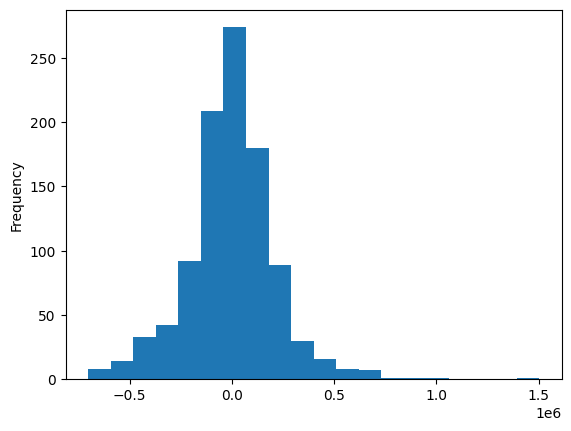

In [68]:
residuos3 = modelo_3.resid
residuos3.plot.hist(bins=20)
plt.show()

### El modelo predice bien para casas con valor esperado menor a US$1M

La heterocedasticidad es un término utilizado en estadística para describir una situación en la que la varianza de los errores (o residuos) de un modelo de regresión no es constante a lo largo del rango de valores previstos. En términos simples, si la dispersión de los residuos varía en diferentes niveles del predictor, estamos ante la heterocedasticidad.

<img src="https://i.ibb.co/9bmySbm/heterocedasticidad.png" alt="heterocedasticidad" border="0">


Además de un análisis visual de los residuos, existen varias pruebas estadísticas para evaluar formalmente la presencia de heterocedasticidad, como la prueba de White y la prueba de Breusch-Pagan. Estas pruebas ayudan a cuantificar si la varianza de los residuos está relacionada con los valores previstos, proporcionando una base más sólida para decidir si la heterocedasticidad es una preocupación significativa en el modelo.

In [85]:
from statsmodels.stats.diagnostic import het_breuschpagan

# residuos del modelo
residuos = modelo_3.resid

# matriz X usada en el modelo (con constante)
exog = modelo_3.model.exog

# Test Breusch-Pagan
bp_test = het_breuschpagan(residuos, exog)

labels = [
    'LM Statistic',
    'LM-Test p-value',
    'F-Statistic',
    'F-Test p-value'
]

pd.DataFrame.from_dict(dict(zip(labels, bp_test)), orient='index', columns=['Valor'])

,Valor
LM Statistic,1.432201e+02
LM-Test p-value,5.769554e-30
F-Statistic,4.154111e+01
F-Test p-value,2.995899e-32


In [86]:
lm, lm_pvalue, fvalue, f_pvalue = bp_test

print("\nBreusch-Pagan Test")
print("-"*40)
print(f"LM Statistic : {lm:.4f}")
print(f"LM p-value   : {lm_pvalue:.6f}")
print(f"F Statistic  : {fvalue:.4f}")
print(f"F p-value    : {f_pvalue:.6f}")

if lm_pvalue < 0.05:
    print("\n⚠️ Evidencia de heterocedasticidad")
else:
    print("\n✅ No se detecta heterocedasticidad")


Breusch-Pagan Test
----------------------------------------
LM Statistic : 143.2201
LM p-value   : 0.000000
F Statistic  : 41.5411
F p-value    : 0.000000

⚠️ Evidencia de heterocedasticidad


In [88]:
import plotly.express as px

fig = px.scatter(
    x=modelo_3.fittedvalues,
    y=residuos,
    labels={'x':'Valores Ajustados','y':'Residuos'},
    title='Residuals vs Fitted'
)

fig.add_hline(y=0, line_dash="dash", line_color="red")

fig.show()

# Otras actividades

## Pickle

Al desarrollar modelos de regresión con Statsmodels, es común querer guardar estos modelos para uso futuro, ya sea para implementación en producción, compartir con otros miembros del equipo o simplemente para respaldo. Una manera conveniente de hacer esto en Python es usando la biblioteca pickle, que permite serializar objetos de Python en archivos y deserializarlos de vuelta a objetos de Python. Esta biblioteca no necesita ser instalada, ya que viene por defecto en Python.

Vamos a explorar cómo guardar un modelo de regresión lineal de Statsmodels con la biblioteca pickle y luego cómo leer el archivo.

In [57]:
"""
Después de entrenar el modelo,
 podemos guardarlo en un archivo usando la biblioteca pickle.
 Para ello, es necesario importar la biblioteca y luego
 podemos usar la función pickle.dump(), indicando el modelo
 y el archivo como parámetros.
"""

import pickle

# Nombre del archivo donde se guardará el modelo
nombre_archivo = 'modelo_regresion_lineal.pkl'

# Guardar el modelo en un archivo usando pickle
with open(nombre_archivo, 'wb') as archivo:
    pickle.dump(modelo, archivo)

In [58]:
"""
Cargar el Modelo de vuelta con Pickle:
Después de guardar el modelo, podemos cargarlo de
 para uso posterior. Para hacer esto, simplemente
 usamos el método pickle.load() utilizando el
 archivo como parámetro de la función
 """
# Cargar el modelo de vuelta del archivo
with open(nombre_archivo, 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)


In [59]:
modelo_cargado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        precio_de_venta   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     467.1
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          4.15e-227
Time:                        17:07:30   Log-Likelihood:                -13790.
No. Observations:                1006   AIC:                         2.759e+04
Df Residuals:                    1001   BIC:                         2.762e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -1.3e+05   2.98e+04     -4.367      0.000   -1.88e+05   -7.16e+04
area_primer_piso             6119.6532    286.041     21.394      0.000    5558.344    6680.963
tiene_segundo_piso           2.213e+05   1.79e+04     12.390      0.000    1.86e+05    2.56e+05
cantidad_banos                1.49e+05   1.58e+04      9.407      0.000    1.18e+05     1.8e+05
calidad_de_cocina_excelente  4.444e+05   2.88e+04     15.437      0.000    3.88e+05    5.01e+05
==============================================================================
Omnibus:                      119.666   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.200
Skew:                           0.403   Prob(JB):                    6.39e-137
Kurtosis:                       6.783   Cond. No.                         547.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Actividad 1

Como persona Científica de Datos, estás a cargo del análisis del problema de fijación de precios de habitaciones de hoteles, utilizando el conjunto de datos proporcionado. Para ello, dispones de este dataset:hoteis.csv.

En esta actividad, tu tarea consiste en llevar a cabo las siguientes etapas:

1. análisis inicial con el PairPlot de Seaborn

2. construir modelos de regresión lineal

3. realizar la comparación de estos modelos.

In [60]:
import pandas as pd
import numpy as np

#https://github.com/JCSR2022/Alura_Data_Science/blob/main/Testing_Relationships_with_Linear_Regression/hoteis.csv

git_raw = 'https://raw.githubusercontent.com/'
url_github_act1 = 'JCSR2022/Alura_Data_Science/main/Testing_Relationships_with_Linear_Regression/hoteis.csv'
df_act1 = pd.read_csv(git_raw + url_github_act1)

df_act1.head()

In [61]:
df_act1.info()

NameError: name 'df_act1' is not defined

In [ ]:
df_act1.describe()

In [ ]:
#Precios negativos no tienen sentido, se eliminaran
df_act1[df_act1['Preco'] <= 0].shape

In [ ]:
df_act1 = df_act1[df_act1['Preco'] > 0]
df_act1.shape

### Métodos automáticos de selección de variables

1. El método de forward selection comienza con un modelo sin variables explicativas y agrega una a una, eligiendo en cada paso la variable que más mejora el modelo de acuerdo con un criterio estadístico específico, como el menor valor de p-valor o el mayor aumento en el R² ajustado.

2. El backward selection inicia con todas las variables posibles en el modelo y, de manera iterativa, elimina la variable que menos contribuye al modelo, nuevamente basándose en criterios como el p-valor o el impacto en el R² ajustado.

3. El stepwise selection es una combinación de los dos métodos anteriores, donde las variables pueden ser agregadas o eliminadas en cada paso, dependiendo de su contribución a la mejora del modelo.

Estos métodos de selección automática son herramientas poderosas que ayudan en la identificación del modelo más parsimonioso, es decir, aquel que puede explicar los datos de manera eficiente sin ser excesivamente complejo. Sin embargo, es crucial que el científico de datos comprenda y supervise el proceso, ya que la elección automática puede, a veces, introducir sesgo o sobreajuste, especialmente si el criterio de selección no es bien elegido o si el modelo no es validado adecuadamente con datos nuevos o de prueba.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1, Se verifica la correlacion

corr_act1 = df_act1.corr()

corr_precio_act1 = corr_act1['Preco'].sort_values(ascending=False).drop('Preco')
vis_corr_precio_act1= (
    corr_precio_act1
    .to_frame(name='Correlation con respecto al precio')
    .style
    .background_gradient(cmap='coolwarm')
    .format("{:.3f}")
)
display(vis_corr_precio_act1)


plt.figure(figsize=(8,6))
sns.heatmap(corr_act1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
sns.pairplot(df_act1)

In [ ]:
df_act1.columns

In [ ]:
"""
Existe alta correlacion entre las 3 varibles y precio, adicional no existe correlacion entre las variables, todas son independientes,
por lo que se utlizaran todas las variable y solo para demostrar se hara un  backward selection solo para confirmar
"""

from sklearn.model_selection import train_test_split
#set random
my_random_state = 230

y = df_act1['Preco']
x = df_act1.drop(columns='Preco')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=my_random_state)

df_act1_train = pd.DataFrame(x_train)
df_act1_train['Preco'] = y_train

df_act1_test = pd.DataFrame(x_test)
df_act1_test['Preco'] = y_test


In [ ]:
import statsmodels.api as sm

#OLS requires an intercept term in the regression equation. Use sm.add_constant() to add this term:
x_train = sm.add_constant(x_train)

# Creando el modelo de regresión (con todas las variables):
modelo_act1 = sm.OLS(y_train, x_train)
results_act1 = modelo_act1.fit()


In [ ]:
#evaluando el modelo
print(results_act1.summary())

In [ ]:
def regression_report(results):

    print("========== MODEL PERFORMANCE REPORT ==========\n")

    print(f"R²: {results.rsquared:.3f}")
    print(f"Adjusted R²: {results.rsquared_adj:.3f}")

    if results.rsquared > 0.7:
        print("✅ Model explains a high proportion of variance.")
    else:
        print("⚠️ Model explanatory power may be limited.")

    print("\n--- Global Significance ---")
    print(f"F-statistic: {results.fvalue:.3f}")
    print(f"Prob(F-statistic): {results.f_pvalue:.6f}")

    if results.f_pvalue < 0.05:
        print("✅ Model is statistically significant.")
    else:
        print("⚠️ Model is NOT statistically significant.")

    print("\n--- Coefficient Significance ---")

    for var, pval in results.pvalues.items():
        significance = "Significant ✅" if pval < 0.05 else "Not significant ⚠️"
        print(f"{var}: p-value={pval:.6f} → {significance}")

regression_report(results_act1)

In [ ]:
#realizando prediccion
from sklearn.metrics import r2_score, mean_squared_error


# add constant to test
x_test_sm = sm.add_constant(x_test)

# predictions
y_pred = results_act1.predict(x_test_sm)


r2_test = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n========== TEST PERFORMANCE ==========")
print(f"Test R²: {r2_test:.3f}")
print(f"RMSE: {rmse:.3f}")

In [ ]:
import plotly.express as px

def plot_predictions(y_true, y_pred):

    df_plot = {
        "Actual Price": y_true,
        "Predicted Price": y_pred
    }

    fig = px.scatter(
        df_plot,
        x="Actual Price",
        y="Predicted Price",
        trendline="ols",
        opacity=0.7
    )

    fig.add_shape(
        type="line",
        x0=y_true.min(),
        y0=y_true.min(),
        x1=y_true.max(),
        y1=y_true.max(),
        line=dict(dash="dash", color="red")
    )

    fig.update_layout(
        title="Actual vs Predicted Values",
        template="simple_white",
        width=700,
        height=500
    )

    return fig

plot_predictions(y_test, y_pred)

## Actividad 2

En esta actividad, vamos a aplicar los conceptos de multicolinealidad y homocedasticidad en un contexto diferente: el sector de energía. Utilizaremos este dataset 'usina.csv' de una planta de energía para explorar cómo estos conceptos pueden afectar nuestros modelos de regresión.

- Primera etapa: Verifica la multicolinealidad utilizando el concepto de VIF. Si hay indicios de multicolinealidad entre las variables, intenta pensar en qué medidas se pueden tomar. Para ello, deberás construir un modelo de regresión lineal asumiendo que la columna PE es la variable y.


- Segunda etapa: Realiza un análisis de residuos e identifica si hay o no heterocedasticidad en los datos.

In [91]:
import pandas as pd
import numpy as np

#https://github.com/JCSR2022/Alura_Data_Science/blob/main/Testing_Relationships_with_Linear_Regression/usina.csv

git_raw = 'https://raw.githubusercontent.com/'
url_github_act2 = 'JCSR2022/Alura_Data_Science/main/Testing_Relationships_with_Linear_Regression/usina.csv'
df_act2 = pd.read_csv(git_raw + url_github_act2)

df_act2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [92]:
df_act2.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
